# Resizing Images with Nearest Neighbor and Bilinear Interpolation 


## Motivation

One of the interesting thing we can do with images in Python is trying to rescale them or rotate them. In general, these procedures are really easy to do on softwares like Photoshop, all you have to do is the method to rescale the picture (examples: Bicubic, Nearest Neighbor and Bilinear).  

Bilinear sampling/scaling is usefull in modern real-time 3D graphics like 3D games. The reason behind this is that there are dedicated hardware parts for that operation in every GPU and it's dirt cheap to use. Some games in some situations use nearest neighbour, usually for style, like Minecraft. Indeed, in Minecraft, blocks keep the same texture even when you are close.

In the early-to-mid '90s, nearest neighbour were really popular, because there was no GPU for the computations. Also, CPU could not afford to waste cycles on interpolation math for every single screen pixel. Early 3D home consoles (like Playstation 1) did the same.

In this notebook, we will see how we can implement bilinear interpolation and nearest neighbor interpolation from scratch.

## Importing Data

For the sake of simplicity, we will use a small picture (200 pixels by 200 pixels). This will give us results quickly. The choosen image is an image of a cat. This picture is useful for two reasons. First, it displays reality (not a drawing) and it can leads us to see the effect of our transformation on a real picture. Secondly, some numbers are displayed on the right side of the picture and make us see the effect of resizing on the numbers.

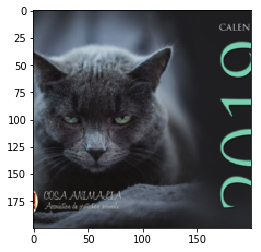

In [2]:
# Import packages
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from functools import partial

# Import the image to resize
nested_arrays = io.imread(r'chat\chat.png')
imgplot = plt.imshow(nested_arrays)

## Understanding Resizing Concept

### Resizing by columns 

An image can be see as a grid of pixels. What we want to do is to expand this grid of pixels. Thus, we will divide these pixels into a new gride. Lets suppose that we have a 2 pixels by 2 pixels image and that we want to transform it into a 3 pixels by 3 pixels image. In this case, one could think about placing one pixel in each corner of this 3x3 grid. This is a good idea, but we must code something that can generalize this for all sizes.

Let $\mathbf{X}$ be the matrix of pixels of our current image (size: $m$ by $n$) and $\mathbf{X}^{\star}$ (size: $M$ by $N$) be the matrix of pixels of our new image. First, let's try to proceed to a resizing in terms of width (columns). Let's consider a fixed row of the new image, we can measure the distance with near pixels (in other words the pixels of the original image) with the following formula:
$$
d_{i} = i\cdot\frac{n}{N}\quad\forall i\in \{0,1,2,...,N\}
$$
Let's consider $d_{1}=0.4$. Then, we can deduce that the nearest pixel is the pixel at position $0$. If we want to do an average of the left and right neighbor, we simply use a convex combination of these pixels. For our previous example, we obtain $w_{\text{right}}=0.4$ and $w_{\text{left}}=0.6$. 

### Resizing by rows 

Now, that we have defined a way to resize columns for a new image, we have to do the same thing for the rows! In fact, the image that we import is express as a list of list where each list represent a row of the original image. Here is a simple trick. After the columns transformation, we have to find a transformation that is invariant to the columns (in other words that does not change the columns that we just created) and that transforms our original rows to the new rows. 

A transformation that posseses these properties is the transpose. First, we apply the resizing in the columns. Secondly, we transpose this new image. Thirdly, we apply the resizing to the columns (we are now resizing the rows of the original image!). Finally, we transpose our new image.

## Implement Nearest Neighbor

The following code implements two methods of image resizing: nearest neighbors and bilinear interpolation. We create some basic functions and we wrap it in a class named ImageResizer. 

In [1]:
def transpose_image(nested_arrays):
    """
    Transpose the nested_arrays structure.
    nested_arrays: A list of list of pixels.
    """
    transposed_tuples = list(zip(*nested_arrays))
    transposed_arrays = [list(row) for row in transposed_tuples]
    return transposed_arrays 

In [47]:
def reformat(method,nested_arrays,nb_row,nb_column):
    """
    Reformat the image using a specified method.
    nested_arrays: A list of list of pixels.
    nb_row: Number of row for the new image.
    nb_column: Number of column for the new image.
    """
    particular_method = partial(method,new_nb_column=nb_column)
    row_transformed = np.array(particular_method(nested_arrays))
    transposition = transpose_image(row_transformed)
    revised_particular_method = partial(method,new_nb_column=nb_row)
    row_column_transformed = np.array(revised_particular_method(transposition))
    return transpose_image(row_column_transformed)

In [3]:
def bilinear_interpolation(nested_arrays,new_nb_column):
    """
    Reformat the image columns using bilinear interpolation method.
    nested_arrays: A list of list of pixels.
    new_nb_column: Number of column for the new image.
    """
    nb_row = len(nested_arrays)
    nb_column = len(nested_arrays[0])
    
    new_image = []
    weights = [(nb_column-1)*i/new_nb_column for i in range(new_nb_column)]
    for row in nested_arrays:
        new_row = [(np.rint(np.add(row[int(weight)+1]*(weight-int(weight)),row[int(weight)]*(1-(weight-int(weight)))))).astype(np.uint8) for weight in weights]
        new_image.append(new_row)
    return new_image

In [4]:
def nearest_neighbor(nested_arrays,new_nb_column):
    """
    Reformat the image rows using nearest neighbor method.
    nested_arrays: A list of list of pixels.
    new_nb_column: Number of column for the new image.
    """
    nb_row = len(nested_arrays)
    nb_column = len(nested_arrays[0])
    new_image = []
    
    weights = [(nb_column-1)*i/new_nb_column for i in range(new_nb_column)]
    new_row_index = [round(weight) for weight in weights]
    for row in nested_arrays:
        new_row = [row[index] for index in new_row_index]
        new_image.append(new_row)  
    return new_image

In [133]:
import matplotlib.pyplot as plt
import importlib
import skimage.io as io
from functools import partial
import numpy as np
import re

class ImageResizer:
    
    def __init__(self, image_path):
        directory = re.split(r'\\',image_path)[:-1]
        self.image_directory = r'\\'.join(directory)
        self.image = io.imread(image_path)
        self.nn_new_image = None
        self.bi_new_image = None
        
    def resize(self, new_nb_rows, new_nb_columns):
            self.nn_new_image = reformat(nearest_neighbor,self.image, new_nb_rows, new_nb_columns)
            self.bi_new_image = reformat(bilinear_interpolation,self.image, new_nb_rows, new_nb_columns)
            print("Your images have been resized successfully.")
        
    def save_new_images(self, image_path):
        if self.nn_new_image!=None:
            io.imsave(image_path + r'\\'+'chat_nn.png', self.nn_new_image)
            print("Image resized with nearest neighbor has been saved successfully.")
        if self.bi_new_image!=None:
            io.imsave(image_path + r'\\'+'chat_bi.png', self.bi_new_image)
            print("Image resized with bilinear interpolation has been saved successfully.")

    def print_old_image(self):
        plt.imshow(self.image)
    
    def print_new_images(self):
        if (self.nn_new_image!=None and self.bi_new_image!=None):
            fig, axs = plt.subplots(1, 2,figsize=(15,15))
            fig.subplots_adjust(wspace=0, hspace=0)
            axs[0].imshow(self.nn_new_image)
            axs[0].set_title('Nearest Neighbor')
            axs[0].set_xticklabels([])
            axs[0].set_yticklabels([])

            axs[1].imshow(self.bi_new_image)
            axs[1].set_title('Bilinear Interpolation')
            axs[1].set_xticklabels([])
            axs[1].set_yticklabels([])
            fig.savefig(self.image_directory + r'\new_images_subplot.png',bbox_inches='tight')
        else:
            print('You did not resize your images yet.')

## Example

Here is a simple example that we did. A small image (200 pixels by 200 pixels) has been choosen to make the resizing computationally easier. Also, the image is compose of a real life animal and some numbers. These components allow us to see some interesting properting of each method.

In [134]:
import importlib
image = ImageResizer(r'chat\chat.png')

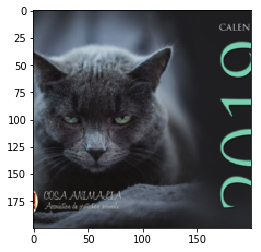

In [135]:
image.print_old_image()

In [136]:
image.resize(1000,1000)

Your images have been resized successfully.


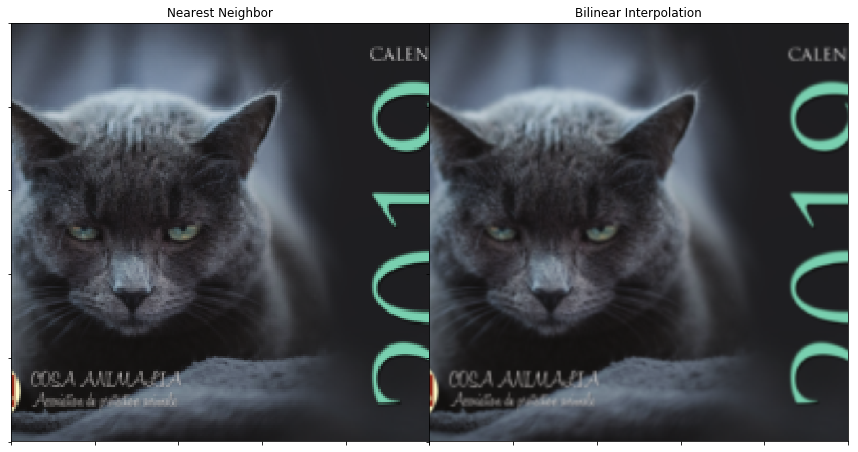

In [137]:
image.print_new_images()

In [138]:
image.save_new_images(r'chat')

Image resized with nearest neighbor has been saved successfully.
Image resized with bilinear interpolation has been saved successfully.


You can notice that bilinear interpolation is more smooth on the curves and hides more the pixels spots on the picture. To conclude, I would like to specify that another interesting method to rescale an image is the bicubic interpolation. This method uses the mathematical concept of splines 